## Part IV.1: Experiments with CNN Model Architecture

In this section, experiments and tuning exercises will be conducted using CNN foundational model architecture.  This will include the following:

1.  Experiments with different CNN model architectures (number of conv layers, etc.)
2.  Experiments with regularization methods (if necessary) including dropout layers, batch normalization, etc.
3.  Hyperparameter tuning/optimization

In [9]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

### Load Prepared Datasets

In [4]:
LOAD_FROM_GDRIVE = True

In [6]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (19524, 24, 32), y: (19524,)
Test data shape: X: (2440, 24, 32), y: (2440,)
Validation data shape: X: (2441, 24, 32), y: (2441,)


In [20]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [10]:
# global default training parameters
NUM_EPOCHS = 75
BATCH_SIZE = 32
LEARNING_RATE = 0.001

### Experiment 1: Baseline CNN Model

In [21]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-1.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

cnn_baseline = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
cnn_baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
)

In [22]:
# Train the model
history_cnn_baseline = cnn_baseline.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - binary_accuracy: 0.9370 - f1_score: 0.1265 - loss: 0.2070 - precision_1: 0.6243 - recall_1: 0.2123 - val_binary_accuracy: 0.9562 - val_f1_score: 0.1273 - val_loss: 0.1557 - val_precision_1: 0.8554 - val_recall_1: 0.4277
Epoch 2/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9604 - f1_score: 0.1253 - loss: 0.1522 - precision_1: 0.8441 - recall_1: 0.5001 - val_binary_accuracy: 0.9623 - val_f1_score: 0.1273 - val_loss: 0.1593 - val_precision_1: 0.8083 - val_recall_1: 0.5843
Epoch 3/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9644 - f1_score: 0.1228 - loss: 0.1393 - precision_1: 0.8583 - recall_1: 0.5468 - val_binary_accuracy: 0.9648 - val_f1_score: 0.1273 - val_loss: 0.1535 - val_precision_1: 0.8175 - val_recall_1: 0.6205
Epoch 4/75
611/611 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9645 - f1_score: 0.1268 - loss: 0.1317 - precision_1: 0.8614 - recall_1: 0.5677 - val_binary_accuracy: 0.

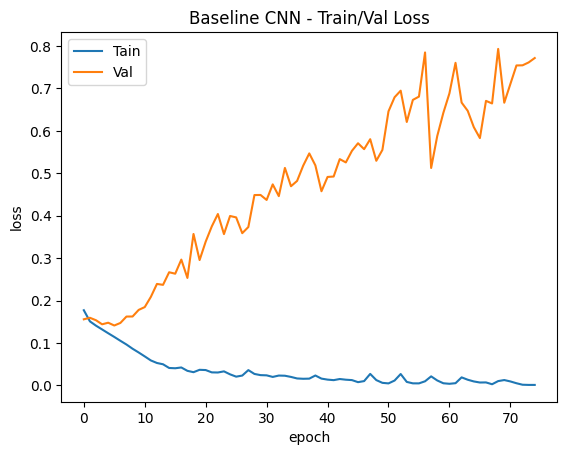

In [23]:
#plot loss
plt.plot(history_cnn_baseline.history['loss'])
plt.plot(history_cnn_baseline.history['val_loss'])
plt.title('Baseline CNN - Train/Val Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Tain', 'Val'])
plt.show()